# Implement certainty estimation on CNN predictions
In this notebook, I implement methods to estimate the certainty of CNN model predictions. Specifically, I train logistic regression models on the CNN's output, evaluate their performance, and discuss the advantages, applications, and limitations of these approaches.

In [1]:
# Install required packages
!pip install h5py
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 18.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 7.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
work_path = "/dss/dsshome1/lxc0B/di29let/ondemand/Projects/Repositories/certainty-estimator"
import torch
import os
import sys
import h5py as h5
import numpy as np
sys.path.append(work_path)
from utils import test
from utils.datasets import MRI_dataset, make_masked_testset, make_noise_testset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
dev = torch.device('cuda:0')

## Generate corrupted predictions

First we need to generate corrupted data by masking parts of the image, as during training. But now using a more convenient function, which allows the generation of specified levels of corruption in images from one of three datasets, now defined as follows:
- Dataset 0: Used for training of the CNN (66% of total data)
- Dataset 1: Used for validation of the CNN or training of the certainty estimators (22% of total data)
- Dataset 2: Used for validation of certainty estimators (18% of total data)

In [4]:
masking_extent = 0.95
pixel_reduction = 32
dataset_nr = 1
test_set = make_masked_testset(masking_extent,pixel_reduction,dataset_nr,dev)
imageloader = iter(DataLoader(test_set,batch_size=16,drop_last=True))
sample_test = next(imageloader)

# to do
# make it showing 3 examples with different masking extent

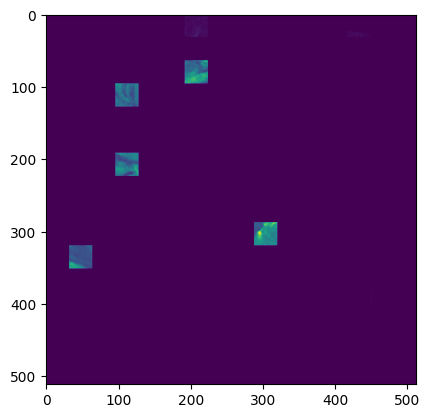

In [6]:
sample_plot = sample_test[0][0,0,:,:].squeeze().cpu()
plt.imshow(sample_plot)
plt.show()

## Generate CNN outputs to train certainty estimators
Next we need to gather the CNN output to train certainty estimators. I tested 2 approaches:
- Get a dropout sample of the logits for each class upon running multiple forward passes on the neural network. In order to provide meaningfull information for the certainty estimation, the samples are ordered by the mean of the values for each class. This way, for a sample size of N, we get 3N samples accross the 3 classes, and the first N samples will belong to the class high highest mean output value, as illustrated below.
  
Insert figure
- Get the high level features from the CNN by extracting the output of the last fully connected layers, consisting in a array of 512 elements.

Isert figure

In [3]:
import time

def generate_corrupt_data(corruption_range,dataset_generator, dataset_nr, dropout_p, mode=['hfeatures'],iterations=60,bsize=16, replicas=5):

    #function to generate dropout distributions
    def prediction_features(sample):
        
        with torch.no_grad():
            if dropout_p == 0:
                mean_pred = net(sample)
                preds = torch.tile(mean_pred.unsqueeze(2),(50,))
            else:
                mean_pred, std_pred, preds = net.get_prediction_stats(sample,n_samples=50, batch_size=bsize)

        predict = torch.argmax(mean_pred,dim=1).to(dev)
        sort_pred = torch.sort(mean_pred,descending=True)

        #calculate quantiles
        dist_qs = []
        for q in np.arange(0.02,1,0.02):
            for cl in range(3):
                dist_qs.append(torch.quantile(preds,q,dim=2)[np.arange(bsize),sort_pred[1][:,cl]])

        return torch.stack(dist_qs,dim=1), predict
    
    wrong = {}
    fts = {}
    for key in mode:
        wrong[key] = []
        fts[key] = []

    features = {}
    predict = {}
    
    start = time.time()

    for nl,corrup in enumerate(corruption_range):
        print(corrup)

        for k in range(replicas):
            #print(corrup, dataset_nr)
            test_set = dataset_generator(corrup, dataset_nr)
            #print(len(test_set))
            imageloader = iter(DataLoader(test_set,batch_size=bsize,drop_last=True))

            for i in range(iterations):
                try:
                    sample = next(imageloader)
                    #print(sample[0].size())
                    with torch.no_grad():
                        if 'hfeatures' in mode:
                            #print('dropout')
                            features['hfeatures'], prediction = net.get_features(sample[0])
                            predict['hfeatures'] = torch.argmax(prediction,dim=1)
                        if 'dropout' in mode:
                            features['dropout'], predict['dropout'] = prediction_features(sample[0])
                            #print(features['features'].size())

                    for mode_name in mode:
                        #print(mode_name)
                        if i==0 and k==0: 
                            wrong[mode_name].append(torch.where(predict[mode_name]!=sample[1].squeeze(),1,0))
                            fts[mode_name].append(features[mode_name])
                            #print(wrong[mode_name].size())
                        else:
                            wrong[mode_name][nl] = torch.concatenate((wrong[mode_name][nl],torch.where(predict[mode_name]!=sample[1].squeeze(),1,0)))
                            fts[mode_name][nl] = torch.concatenate((fts[mode_name][nl],features[mode_name]))
                            #print(len(wrong[mode_name]))
                except:
                    pass

    for mode_name in mode:
        wrong[mode_name] = torch.stack(wrong[mode_name]).cpu()
        fts[mode_name] = torch.stack(fts[mode_name]).cpu()
    
    end = time.time()
    print(end-start)
    
    return fts, wrong

## Test masking with trained models
We are going to test the models trained with different dropout extent on masked validation and test datasets. Two different outputs will be gathered here: the first is the Monte-Carlo dropout output (50 forward passes in the CNN) and the second are the high-level features of the CNN (single forward pass).

In [ ]:
i

In [ ]:
#dropouts = [0,0.005,0.01,0.02,0.05,0.1,0.15,0.2]
#drop_names = ['0','0005','001','002','005','01','015','02']
dropouts = [0.02]

for drop in dropouts:
    print(drop)
    model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop}_nonorm_masked_extendedtrain06/22_10_2024"
    check_path = os.path.join(model_path,f"resnet18_epoc_20")
    net, _ = test.load_model(check_path,dev,drop)
   
    net.dropout.p = drop
    
    fraction_levels = np.arange(0,0.97,0.05)
    uncertainty_features = {key: {} for key in ['train','validation']}

    for i, key in enumerate(uncertainty_features):
        def data_gen(fraction, dataset_nr):
            test_set = make_masked_testset(fraction,32, dataset_nr,dev=dev)
            return test_set
        fts, wrong = generate_corrupt_data(fraction_levels,data_gen, i+1, drop, mode=['dropout','hfeatures'],replicas=2)
        
        uncertainty_features[key]['features'] = fts
        uncertainty_features[key]['wrong'] = wrong
    
    torch.save(uncertainty_features,os.path.join(model_path,'uncertainty_all.pth'))

0.02
0.0


## Train certainty estimators on the CNN outputs
The next step is to train the certainty estimators, based on logistic regression classifiers, on the two types of generated CNN outputs. The CNN validation and test datasets will be used as the training and validation datasets of the uncertainty estimators, respectively.

First, we define a function to get the training data into a dictionary and train the estimator models.

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
fraction_levels = np.arange(0,0.97,0.05)

In [12]:
# load train data to a dictionary and train uncertainty estimators
dropouts = [0,0.005,0.01,0.05,0.1,0.15,0.2]
drop_names = ['0','0.005','0.01','0.05','0.1','0.15','0.2']
estimator_type = ['dropout','hfeatures']

def train_estimators(C=[1,1],dropout_predictions=False,features_file = 'uncertainty_all.pth',clf=None):
    uncertainty_drops = {}
    
    
    for type in estimator_type:
        uncertainty_drops[type] = {key: {} for key in drop_names}
    
    for drop_name in drop_names:
        
        model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop_name}_nonorm_masked_extendedtrain06/22_10_2024"     
        uncertainty_tm = torch.load(os.path.join(model_path,features_file))
        
        for i, type in enumerate(estimator_type):
        
            print(drop_name)
            
            for key in ['train','validation']:
                uncertainty_drops[type][drop_name][key] = {}
                for data_name in ['features','wrong']:
                    uncertainty_drops[type][drop_name][key][data_name] = uncertainty_tm[key][data_name][type]
            
            #fit logistic model
            if dropout_predictions:
                pred_type = 'dropout'
            else:
                pred_type = type
                
            fts = uncertainty_drops[type][drop_name]['train']['features']
            wrong = uncertainty_drops[pred_type][drop_name]['train']['wrong']
            Xtrain = fts.view(-1,fts.size(2))
            gind = torch.where(torch.isnan(Xtrain[:,1])==0)[0]
            Xtrain = Xtrain[gind,:]
            wrong_train = wrong.view(-1,1)[gind,:]
            y = torch.where(wrong_train==0,1,0).squeeze()

            #fit classifier
            if not clf:
                uncertainty_drops[type][drop_name]['clf'] = LogisticRegression(C=C[i],random_state=0,max_iter=3000).fit(Xtrain, y)
            else:
                uncertainty_drops[type][drop_name]['clf'] = clf[type][drop_name]['clf']
    
    return uncertainty_drops

Then we define a function to check how the uncertainty estimators perform by comparing their probability output with actuall accuracies.

In [7]:
from sklearn.linear_model import LinearRegression

hbins = np.arange(0.3,1.02,0.02)

def get_estimator_accuracy(uncertainty_drops,dataset='validation',estimator_mix=False,masking_levels=None):
    
    uncertainty_drops['model confidence'] = hbins[:-1]+0.01
    
    
    for type in estimator_type:
        for drop_name in drop_names:
            
            fts_val = uncertainty_drops[type][drop_name][dataset]['features']
            wrong_val = uncertainty_drops[type][drop_name][dataset]['wrong']
            X = fts_val.view(-1,fts_val.size(2))

            # Histograms of estimator output probability of a sample being correct
            # All predictions
            if estimator_mix:
                pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(fts_val).reshape(-1,1)
            else:
                
                pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(X)[:,1]
                
            b = np.histogram(pred_proba,bins=hbins)
            
            # Wrong predictions 
            c = np.histogram(pred_proba[wrong_val.view(-1,1).squeeze()==1],bins=hbins)
            
            #get global nan indices
            with np.errstate(divide='ignore', invalid='ignore'):
                ind_nan = ~np.isnan(1-c[0]/b[0])
                uncertainty_drops[type][drop_name]['global_nan_bin'] = ind_nan
               
            #store stats in dictionary
            uncertainty_drops[type][drop_name]['acc_total'] = 1-c[0]/b[0]
            uncertainty_drops[type][drop_name]['conf_total'] = b[0]
            uncertainty_drops[type][drop_name]['accuracy'] = 1 - torch.sum(wrong_val.view(-1,1))/wrong_val.view(-1,1).size(0)

            # The same for each masking extent
            predm = []
            pred_acc = []
            uncertainty_drops[type][drop_name]['nan_bin'] = []

            for ind in range(fts_val.size(0)):
                if estimator_mix:
                    pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(fts_val[ind,:,:].squeeze(),
                                                                                         mask_levels=masking_levels[ind]).reshape(-1,1)
                else:
                    pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(fts_val[ind,:,:].squeeze())[:,1]
                    
                bm,_ = np.histogram(pred_proba,bins=hbins)
                cm,_ = np.histogram(pred_proba[wrong_val[ind,:]==1],bins=hbins)

                with np.errstate(divide='ignore', invalid='ignore'):
                    pred_acc.append(1-cm/bm)
                    predm.append(bm/np.max(bm))
                    ind_nan = ~np.isnan(1-cm/bm)
                    uncertainty_drops[type][drop_name]['nan_bin'].append(ind_nan)

            uncertainty_drops[type][drop_name]['acc_bin'] = np.array(pred_acc)
            uncertainty_drops[type][drop_name]['conf_bin'] = np.array(predm)
            uncertainty_drops[type][drop_name]['nan_bin'] = np.array(uncertainty_drops[type][drop_name]['nan_bin'])
    
    return uncertainty_drops

Finally, we compute some usefull statistics to compare different estimators

In [8]:
stat_names = ['accuracy','hconf']

def get_estimator_stats(uncertainty_drops,corruption_levels):
    stats = {}
    for type in estimator_type:
        stats[type] = {key:{} for key in ['total', 'binned']}
        for key in stats[type]:
            stats[type][key] = {k:[] for k in stat_names}

    for type in estimator_type:
        for drop_name in drop_names:
            #total
            ind_nan = uncertainty_drops[type][drop_name]['global_nan_bin']
            xp = uncertainty_drops['model confidence'].reshape(-1,1)[ind_nan]
            yp = uncertainty_drops[type][drop_name]['acc_total'][ind_nan]
            stats[type]['total']['accuracy'].append(uncertainty_drops[type][drop_name]['accuracy'])

            #binned
            h_conf = []
            
            for i in range(corruption_levels.shape[0]):
                ind_nan = uncertainty_drops[type][drop_name]['nan_bin'][i,:]
                yp = uncertainty_drops[type][drop_name]['acc_bin'][i,ind_nan]
                xp = uncertainty_drops['model confidence'][ind_nan].reshape(-1,1)
                h_conf.append(np.mean(yp[xp[:,0]>0.9]))

            stats[type]['binned']['hconf'].append(h_conf)

        stats[type]['binned']['hconf'] = np.array(stats[type]['binned']['hconf']).squeeze()
    
    return stats

### Certainty estimation: first glance
First we check the accuracy of the CNN model outputs, used to train the uncertainty estimators, on the masked images (validation set).

In [9]:
accuracy = []
for drop_name in drop_names:
    accuracy.append([uncertainty_drops['dropout'][drop_name]['accuracy'],uncertainty_drops['hfeatures'][drop_name]['accuracy']])

plt.plot(dropouts,np.array(accuracy),'o-')
plt.ylabel('Accuracy on validation set')
plt.xlabel('Dropout fraction')
plt.legend(estimator_type)
plt.show()

NameError: name 'uncertainty_drops' is not defined

### Training certainty estimators and checking their performance
We train the logistic regression estimators for the range of dropouts tested and get the statistics on their performance.

In [13]:
# get statistics using either hfeatures or dropout prediction outputs to train the estimators
uncertainty_drops = get_estimator_accuracy(train_estimators(dropout_predictions=False))
stats = get_estimator_stats(uncertainty_drops,corruption_levels=fraction_levels)

0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2


Before moving on, we just check the overall accuracy of the models to make sure there are no big variations accross conditions.

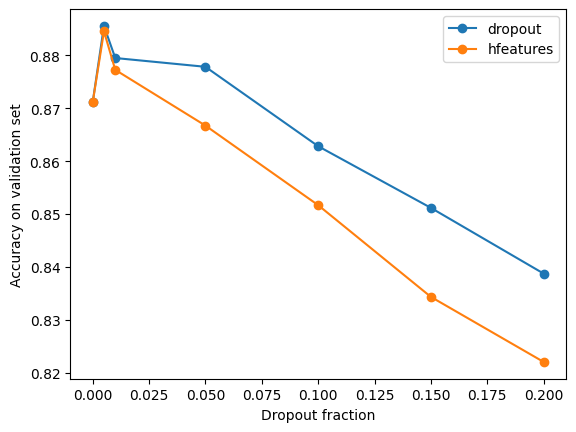

In [14]:
accuracy = []
for drop_name in drop_names:
    accuracy.append([uncertainty_drops['dropout'][drop_name]['accuracy'],uncertainty_drops['hfeatures'][drop_name]['accuracy']])

plt.plot(dropouts,np.array(accuracy),'o-')
plt.ylabel('Accuracy on validation set')
plt.xlabel('Dropout fraction')
plt.legend(estimator_type)
plt.show()

Then we check how well the certainty estimators can predict actual accuracy in the global data, by lamping together all masking levels. Let's have a look at models based on an intermediate dropout level.

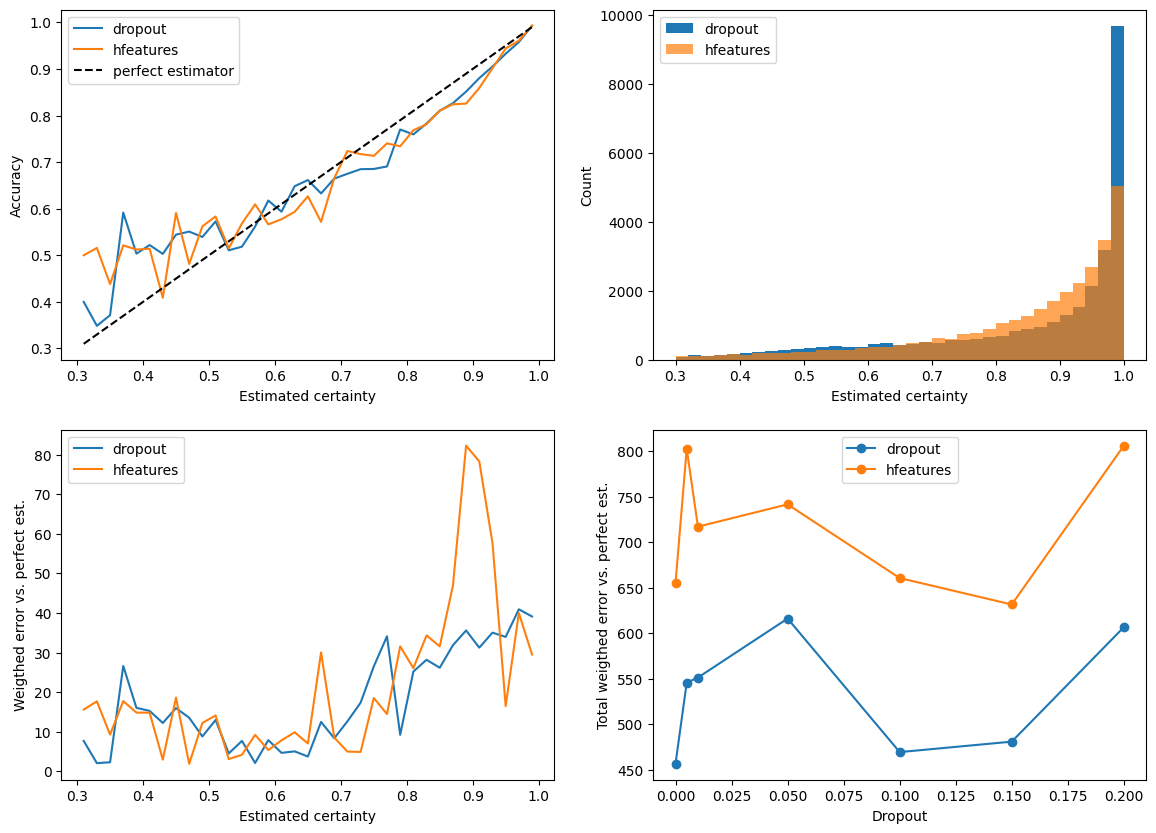

In [17]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
ex_drop = '0.05'
xp = uncertainty_drops['model confidence']
yp = np.array([uncertainty_drops['dropout'][ex_drop]['acc_total'],
               uncertainty_drops['hfeatures'][ex_drop]['acc_total']]).T

axs[0,0].plot(xp,yp)
axs[0,0].plot(xp,xp,color='black',linestyle='dashed')
axs[0,0].set(xlabel='Estimated certainty',ylabel='Accuracy')
axs[0,0].legend([estimator_type[0],estimator_type[1],'perfect estimator'])

yc = np.array([uncertainty_drops['dropout'][ex_drop]['conf_total'],
                uncertainty_drops['hfeatures'][ex_drop]['conf_total']]).T
    
ye = np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc

#compute deviation from perfect estimator for all dropouts
y_err = np.zeros((len(dropouts),2))
for i, drop_name in enumerate(drop_names):
    yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_total'],
               uncertainty_drops['hfeatures'][drop_name]['acc_total']]).T
    
    yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_total'],
                uncertainty_drops['hfeatures'][drop_name]['conf_total']]).T
    
    y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
    
alphas = [1,0.7]
for i in range(2):
    axs[0,1].bar(xp,yc[:,i],width=0.02,alpha=alphas[i])
axs[0,1].set(xlabel='Estimated certainty',ylabel='Count')
axs[0,1].legend(estimator_type)

axs[1,0].plot(xp,ye)
axs[1,0].set(xlabel='Estimated certainty',ylabel='Weigthed error vs. perfect est.')
axs[1,0].legend(estimator_type)

axs[1,1].plot(dropouts,y_err,'o-')
axs[1,1].set(xlabel='Dropout',ylabel='Total weigthed error vs. perfect est.')
axs[1,1].legend(estimator_type)

plt.show()

In this particular example, both estimators perform decently. However, the dropout-based estimator is overall closer to a perfect estimator. The high-level features-based estimator seems to output an excess of under-estimated certainties in the range of 0.7-0.95, resulting in a higher weighted error (defined as deviation from perfect estimator multiplied by number of observations at each bin) particularly in that region. Accross all CNN training dropout extents, the total weighted error is consistently higher for the hfeatures-based estimator vs. its dropout-based counterpart.

### Checking overfitting
These results above suggest that the hfeatures-based estimators might be overfitting on the training data. So, we repeat the analysis for the training set and compare it with the results show above for the validation set.

In [18]:
uncertainty_drops_train = get_estimator_accuracy(train_estimators(),dataset='train')
stats_train = get_estimator_stats(uncertainty_drops_train,corruption_levels=fraction_levels)

0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2


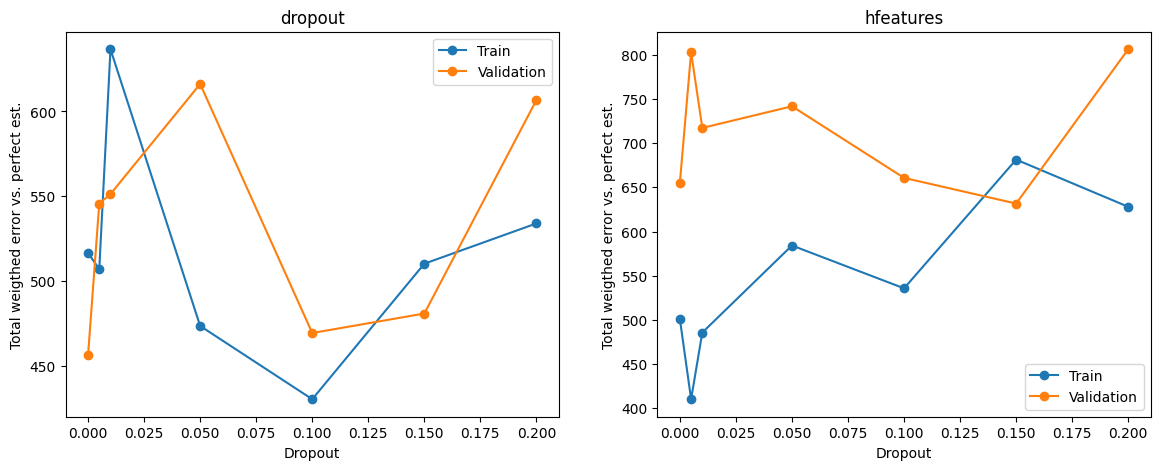

In [19]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
ex_drop = '0.05'
xp = uncertainty_drops['model confidence']
yp = np.array([uncertainty_drops_train['dropout'][ex_drop]['acc_total'],
               uncertainty_drops_train['hfeatures'][ex_drop]['acc_total']]).T

#compute deviation from perfect estimator for all dropouts
y_err_train = np.zeros((len(dropouts),2))
for i, drop_name in enumerate(drop_names):
    yp = np.array([uncertainty_drops_train['dropout'][drop_name]['acc_total'],
               uncertainty_drops_train['hfeatures'][drop_name]['acc_total']]).T

    yc = np.array([uncertainty_drops_train['dropout'][drop_name]['conf_total'],
                uncertainty_drops_train['hfeatures'][drop_name]['conf_total']]).T
    
    y_err_train[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
    

for i in range(2):
    axs[i].plot(dropouts,np.concatenate((y_err,y_err_train),axis=1)[:,[i+2,i]],'o-')
    axs[i].set(xlabel='Dropout',ylabel='Total weigthed error vs. perfect est.',title=estimator_type[i])
    axs[i].legend(['Train','Validation'])

plt.show()

## Hyperparameter tunning
In the training set, the difference between the two types of estimator is less remarkable. The features-based estimators are even the closest to the perfect estimator in this case. This observations point towards overfitting in the training data when using high-level features, so I tested the effect of the regularization parameter C in the loggistic regression fitting.

In [20]:
C_values = np.arange(0.02,0.51,0.1)
hbins = np.arange(0.3,1.02,0.02)
xp = hbins[:-1]+0.01

weighted_err = []

for C in C_values:
    print(C)
    uncertainty_drops = get_estimator_accuracy(train_estimators(C=[C,C]))
    
    w_err = np.zeros((len(dropouts),2))
    for i, drop_name in enumerate(drop_names):
        yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_total'],
                   uncertainty_drops['hfeatures'][drop_name]['acc_total']]).T

        yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_total'],
                uncertainty_drops['hfeatures'][drop_name]['conf_total']]).T
    
        w_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
       
    weighted_err.append(w_err)

0.02
0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2
0.12000000000000001
0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2
0.22
0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2
0.32000000000000006
0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2
0.42000000000000004
0
0
0.005
0.005
0.01
0.01
0.05
0.05
0.1
0.1
0.15
0.15
0.2
0.2


In [50]:
stats_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/tests/22_10_24'
if not os.path.isdir(stats_path):
    os.makedirs(stats_path)
np.save(os.path.join(stats_path,'W_err.npy'),weighted_err)

In [13]:
#load data
C_values = np.arange(0.02,1.01,0.02)
stats_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/tests'
weighted_err = np.load(os.path.join(stats_path,'W_err.npy'))

In [23]:
sum_err.shape

(5, 2)

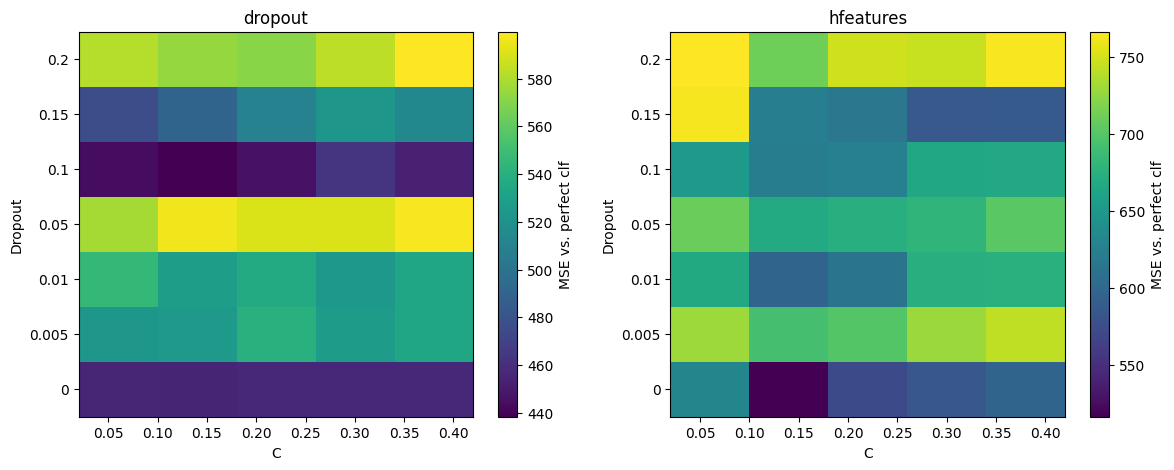

In [24]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
pcm = [1,1]
cbar = [1,1]

sum_err = np.sum(np.array(weighted_err),axis=1)

for i,type in enumerate(estimator_type):
    pcm[i] = axs[i].imshow(np.array(weighted_err)[:,:,i].T, aspect='auto',origin='lower',extent=[C_values[0],C_values[-1],0,len(dropouts)])
    axs[i].set(xlabel='C',ylabel='Dropout',title=f"{type}",yticks=np.arange(0.5,len(dropouts)), yticklabels=dropouts)

    cbar[i] = fig.colorbar(pcm[i],ax=axs[i])
    cbar[i].set_label('MSE vs. perfect clf')

plt.show()

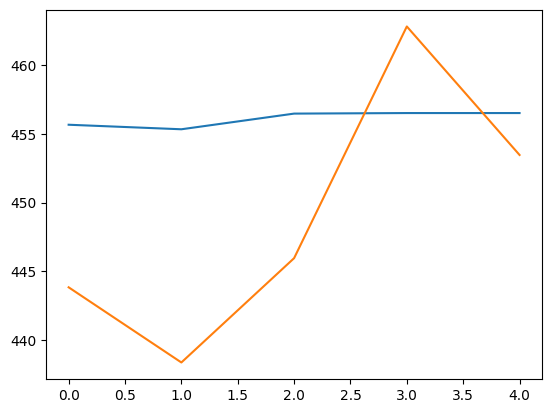

In [32]:
plt.plot(np.array(weighted_err)[:,[0,4],0])
plt.show()

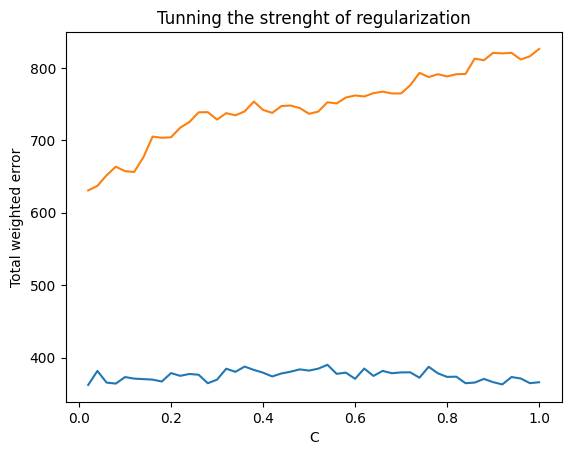

In [34]:
plt.plot(C_values,np.min(sum_err,axis=1))
plt.title('Tunning the strenght of regularization')
plt.ylabel('Total weighted error')
plt.xlabel('C')
plt.show()

The results of the grid search above show that the defalut values of C=1 is already the best in the case of the dropout-based estimator. However, for the hfeaures-based estimator, a low C=0.02 provides optimal performance, tough still poorer than the dropout-based model. Let's now check the estimators' performance using the tunned value of C for each hfeatures-based estimator.

In [ ]:
uncertainty_drops_tunned = get_estimator_accuracy(train_estimators(C=[1,0.02]))
stats_tunned = get_estimator_stats(uncertainty_drops_tunned,corruption_levels=fraction_levels)

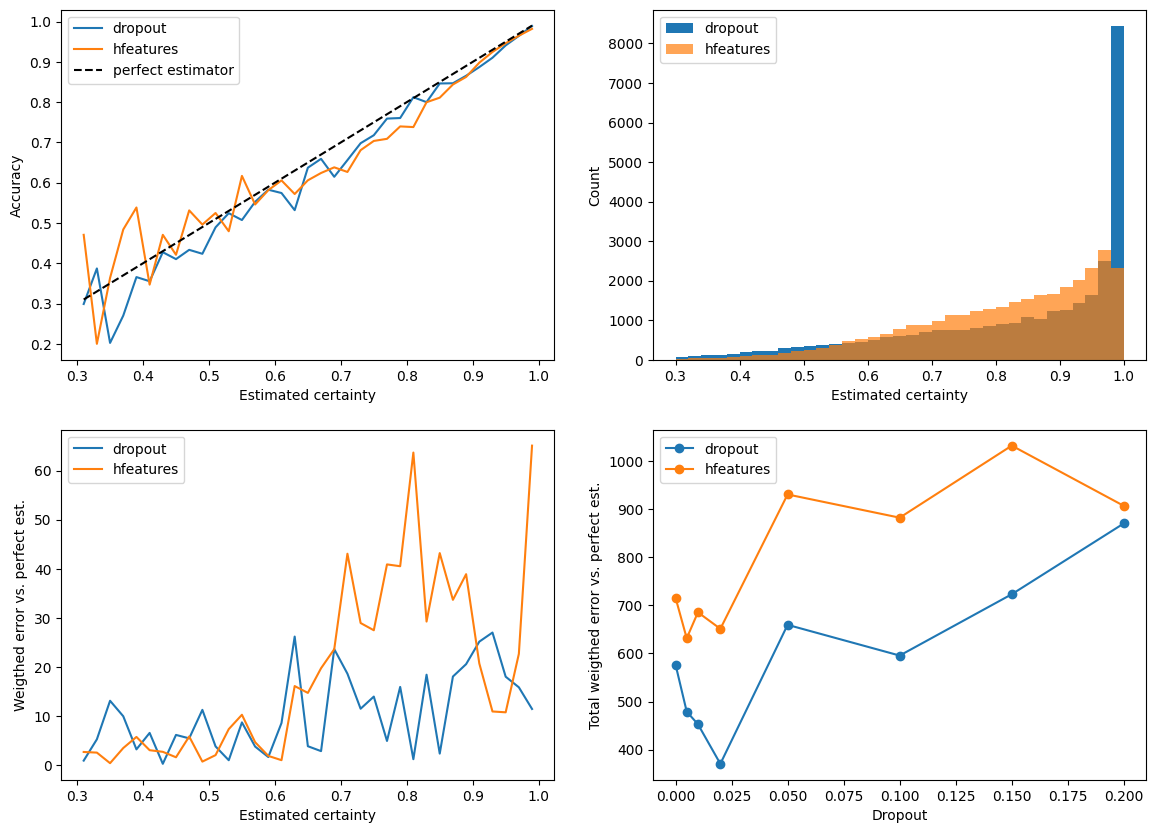

In [19]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
ex_drop = '002'
xp = uncertainty_drops_tunned['model confidence']
yp = np.array([uncertainty_drops_tunned['dropout'][ex_drop]['acc_total'],
               uncertainty_drops_tunned['hfeatures'][ex_drop]['acc_total']]).T

axs[0,0].plot(xp,yp)
axs[0,0].plot(xp,xp,color='black',linestyle='dashed')
axs[0,0].set(xlabel='Estimated certainty',ylabel='Accuracy')
axs[0,0].legend([estimator_type[0],estimator_type[1],'perfect estimator'])

yc = np.array([uncertainty_drops_tunned['dropout'][ex_drop]['conf_total'],
                uncertainty_drops_tunned['hfeatures'][ex_drop]['conf_total']]).T
    
ye = np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc

#compute deviation from perfect estimator for all dropouts
y_err = np.zeros((len(dropouts),2))
for i, drop_name in enumerate(drop_names):
    yp = np.array([uncertainty_drops_tunned['dropout'][drop_name]['acc_total'],
               uncertainty_drops_tunned['hfeatures'][drop_name]['acc_total']]).T

    yc = np.array([uncertainty_drops_tunned['dropout'][drop_name]['conf_total'],
                uncertainty_drops_tunned['hfeatures'][drop_name]['conf_total']]).T
    
    y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
    

alphas = [1,0.7]
for i in range(2):
    axs[0,1].bar(xp,yc[:,i],width=0.02,alpha=alphas[i])
axs[0,1].set(xlabel='Estimated certainty',ylabel='Count')
axs[0,1].legend(estimator_type)

axs[1,0].plot(xp,ye)
axs[1,0].set(xlabel='Estimated certainty',ylabel='Weigthed error vs. perfect est.')
axs[1,0].legend(estimator_type)

axs[1,1].plot(dropouts,y_err,'o-')
axs[1,1].set(xlabel='Dropout',ylabel='Total weigthed error vs. perfect est.')
axs[1,1].legend(estimator_type)

plt.show()

Despite the improvement in the h-features based estimator, its performance is still slightly behing the dropout-based estimator. Interestingly, the latter shows a sweet spot attaining optimal performance at a dropout of 0.02. This showcases the benefits of the extra information obtained when performing MonteCarlo dropout at inference time vs deterministic CNN output, but warns for the carefull selection of the extent of dropout.

## Uncertainty estimation accross masking levels
In addition to the global data, it is improtant to check how robust are the certainty estimators to changes in the degree of image corruption (masking). Below I check certainty estimates for each image masking extent.

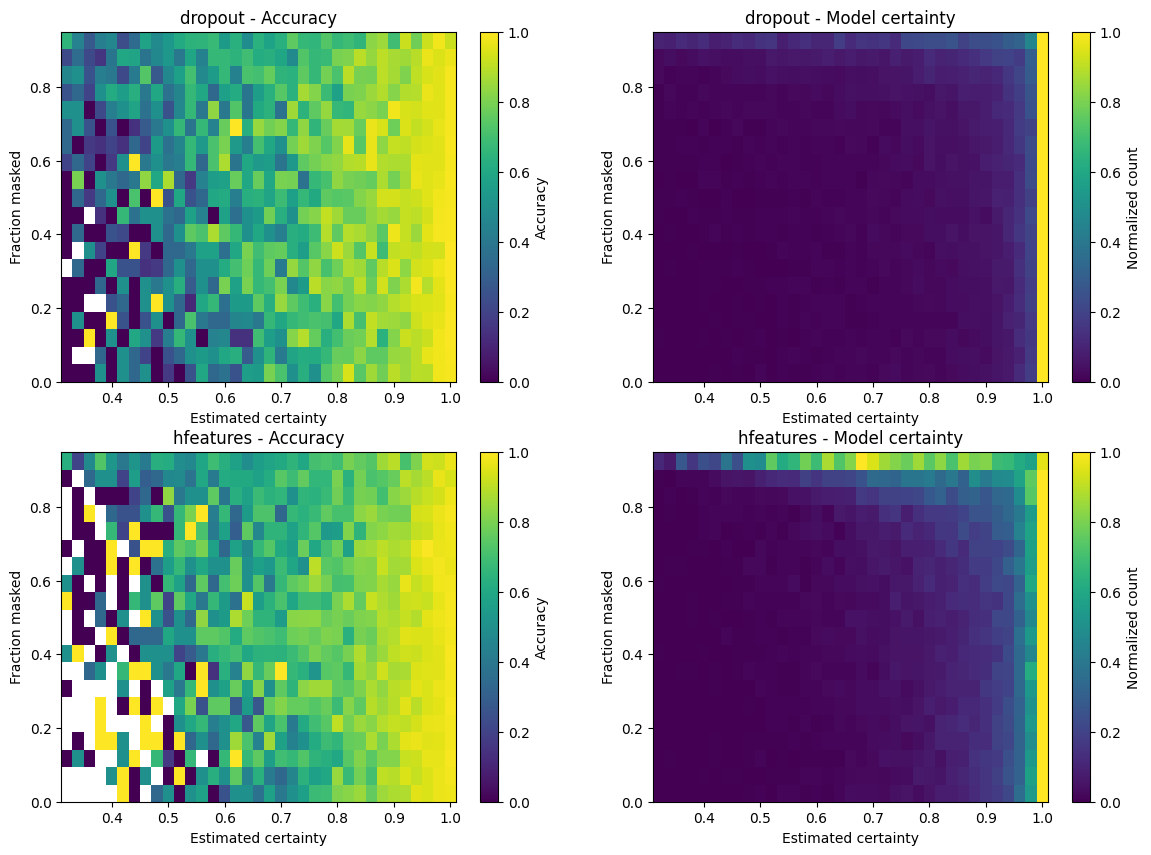

In [13]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
drop_name = '002'
title_names = ['Accuracy','Model certainty']

for i,type in enumerate(estimator_type):

    pred_acc = uncertainty_drops_tunned[type][drop_name]['acc_bin']
    predm = uncertainty_drops_tunned[type][drop_name]['conf_bin']
    
#     for k in range(20):
#         indnan = uncertainty_drops_tunned[type][drop_name]['nan_bin'][k,:]
#         pred_acc[k,indnan] = calibrate_certainty(xp[indnan],pred_acc[k,indnan],predm[k,indnan])
    
    #pred_acc = smooth_and_interpolate_2d(pred_acc,1,5)
    #pred_acc = smooth_and_interpolate_2d(pred_acc,0,3)
    
    pcm1 = axs[i,1].imshow(predm, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,1].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[1]}")

    pcm2 = axs[i,0].imshow(pred_acc, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,0].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[0]}")
    #plt.xlabel('Prediction confidence')
    #plt.ylabel('Fraction masked')
    #axs[0].colorbar(pcm2,label='Accuracy')
    cbar = fig.colorbar(pcm2,ax=axs[i,0])
    cbar.set_label('Accuracy')
    cbar2 = fig.colorbar(pcm1,ax=axs[i,1])
    cbar2.set_label('Normalized count')
plt.show()

Both estimators certainty seem to match well with actual accuracies computed accross a wide range of masking levels (0-0.95). Note that the accuracies corresponding to low certainty estimates are, in general, noisy due to the lack of data on that range. Let's take a closer look at different intervals of estimated certainties and check how well the actual accuracies follow the estimates.

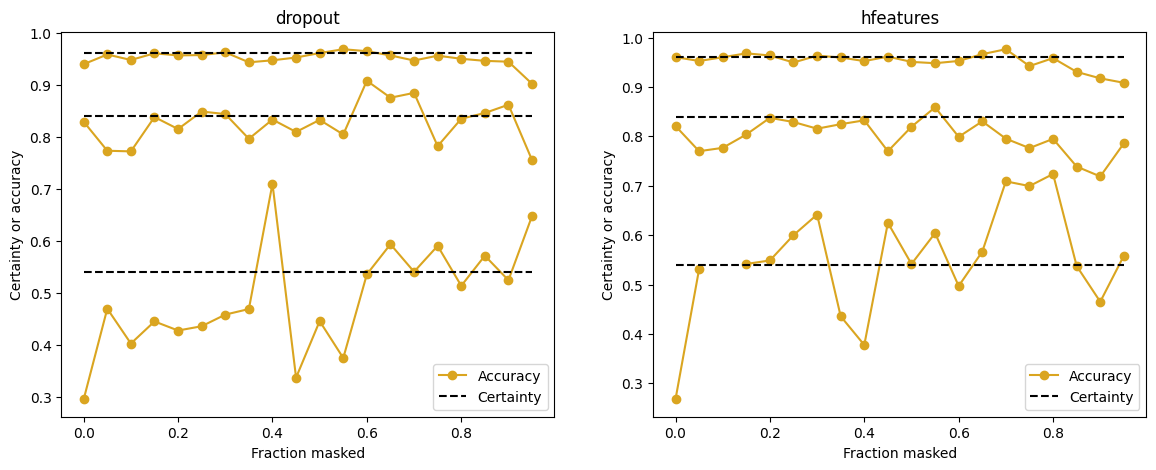

In [21]:
fig, axs = plt.subplots(1,2,figsize=(14,5))

c_ranges = np.stack((np.arange(10,14),np.arange(25,29),np.arange(31,35)),axis=1)

for i,type in enumerate(estimator_type):

    for c in range(3):
        pred_acc = uncertainty_drops_tunned[type][drop_name]['acc_bin']

        axs[i].plot(fraction_levels,np.mean(pred_acc[:,c_ranges[:,c]],axis=1),'o-',color='goldenrod')
        axs[i].plot(fraction_levels,np.tile(np.mean(uncertainty_drops_tunned['model confidence'][c_ranges[:,c]]),20),'--',color='black')
        axs[i].set(xlabel='Fraction masked',ylabel='Certainty or accuracy',title=type)
    axs[i].legend(['Accuracy', 'Certainty'])
plt.show()

I checked 3 intervals of certainty, centered at 0.54, 0.84 and 0.96. As mentioned before, accuracy profiles are noisy for the lowest certainty range. For the highly certain predictions, accuracies closely match certainty but tend to drop at high masking levels, particularly in the case of the h-features based estimator. That trend might be a result of the drop in CNN model accuracy on highly corrupted images. So, I checked how accuracy varies accross masking levels for both estimators.

In [14]:
acc_masking = []
for type in estimator_type:
    inst = uncertainty_drops_tunned[type][drop_name]['validation']['wrong']
    n_total = inst.size(1)
    n_wrong = torch.sum(inst,1)
    acc_masking.append(1-n_wrong/n_total)

In [32]:
def calculate_total_error(uncertainty_drops,corruption_levels):
    
    xp = uncertainty_drops['model confidence']
    y_err = np.zeros((corruption_levels.shape[0],2))
    print(corruption_levels.shape[0])
    for i in range(corruption_levels.shape[0]):
        
#         for k in range(2):
#             ind_nan[k] = uncertainty_drops[estimator_type[k]][drop_name]['nan_bin'][i,:]
        
        yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_bin'][i,:],
               uncertainty_drops['hfeatures'][drop_name]['acc_bin'][i,:]]).T

        yp = np.where(np.isnan(yp),0,yp)
        #print(yp)

        yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_bin'][i,:],
                    uncertainty_drops['hfeatures'][drop_name]['conf_bin'][i,:]]).T
        y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
        
    return y_err

In [21]:
total_binned_error = calculate_total_error(uncertainty_drops_tunned,fraction_levels)

20


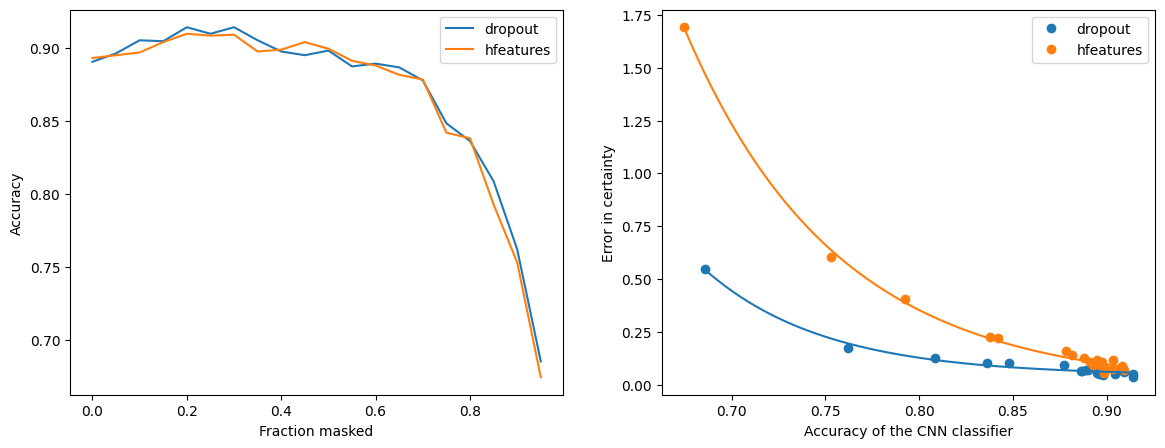

In [87]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
x_names = ['Fraction masked','Certainty']
y_names = 'Accuracy'

for i,type in enumerate(estimator_type):
    axs[0].plot(fraction_levels,acc_masking[i])
    axs[0].set(xlabel='Fraction masked',ylabel='Accuracy')
    axs[0].legend(estimator_type)
    
    pred_acc = uncertainty_drops_tunned[type][drop_name]['acc_bin']
    #axs[1].plot(np.mean(pred_acc[:,c_ranges[:,2]],axis=1),acc_masking[i],'o')
    axs[1].plot(acc_masking[i],total_binned_error[:,i],'o')
    axs[1].set(xlabel='Accuracy of the CNN classifier',ylabel='Error in certainty')
    axs[1].legend(estimator_type)

# Define an exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Get the default color cycle
colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(2):
    params1, _ = curve_fit(exp_decay, np.array(acc_masking[i]),total_binned_error[:,i],p0=[50,7,0])
    
    xfit = np.arange(torch.min(acc_masking[i]),torch.max(acc_masking[i]),0.001)
    axs[1].plot(xfit,exp_decay(xfit,*params1),color=colors_default[i])
    
plt.show()

As expected, accuracy drops with masking extent. Plotting the accuracy at each masking level vs corresponding certainty level reveals an approximately exponential relationshiop between the two variables.

These observations suggest that certainty estimation is coupled with the CNN performance and probably to the extent to which a sample falls withing the distribution of the training data. In this case, the dropout-based estimator seems to be more robust to input corruption (by masking) keeping a good performance for masking levels up to 90%.

## Test the models with different noise levels
Given the previous observations, I tested estimators' performance with a different kind of corruption, not present in the training dataset, consisting in noise addition to the input images. Here, I picked the CNNs trained with a dropout of 0.02 since the best certainty estimators were obtained from their outputs.

In [34]:
dropouts = [0.02]
drop_names = ['002']
estimator_type = ['dropout','hfeatures']
noise_levels = np.arange(0,155,10)

uncertainty_drops_noise = get_estimator_accuracy(train_estimators(C=[1,0.02],features_file='uncertainty_all_noise.pth',
                                                                 clf=uncertainty_drops_tunned))
stats_noise = get_estimator_stats(uncertainty_drops_noise,corruption_levels=noise_levels)

002
002


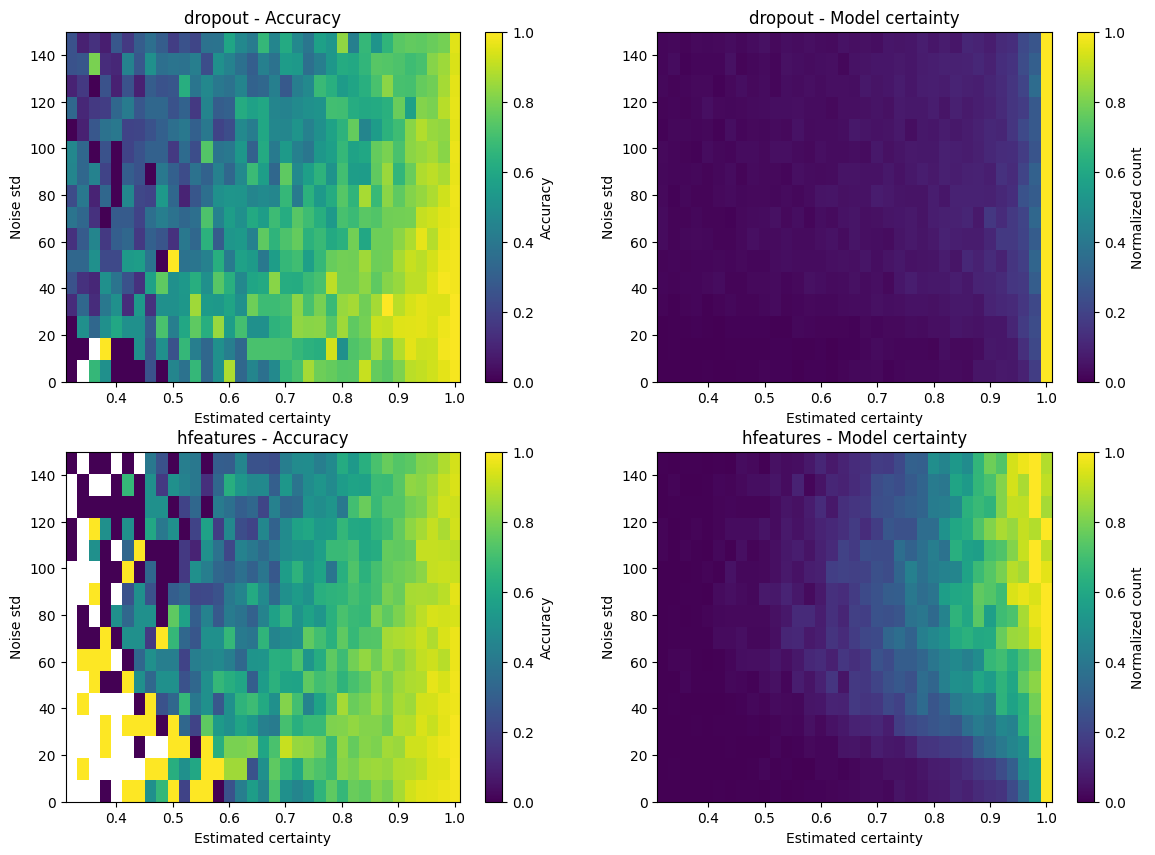

In [35]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
drop_name = '002'
title_names = ['Accuracy','Model certainty']

for i,type in enumerate(estimator_type):

    pred_acc = uncertainty_drops_noise[type][drop_name]['acc_bin']
    predm = uncertainty_drops_noise[type][drop_name]['conf_bin']
    
    pcm1 = axs[i,1].imshow(predm, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,noise_levels[0],noise_levels[-1]])
    axs[i,1].set(xlabel='Estimated certainty',ylabel='Noise std',title=f"{type} - {title_names[1]}")

    pcm2 = axs[i,0].imshow(pred_acc, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,noise_levels[0],noise_levels[-1]])
    axs[i,0].set(xlabel='Estimated certainty',ylabel='Noise std',title=f"{type} - {title_names[0]}")
    cbar = fig.colorbar(pcm2,ax=axs[i,0])
    cbar.set_label('Accuracy')
    cbar2 = fig.colorbar(pcm1,ax=axs[i,1])
    cbar2.set_label('Normalized count')
plt.show()

In this case, the change in certainty estimation with image corruption is more evident for bothe estimators. There seems to be a decrease in actual accuracies for the high range of certainties in both cases (left plots). Interestingly, the estimators' certainty distributions "react" quite differently to the increase in noise. The hfeatures-based estimator outputs much more lower certainty values for large noise levels, something not so evident in the case of dropout-based certainties.

Let's have a look at selected certainty ranges, as shown before.

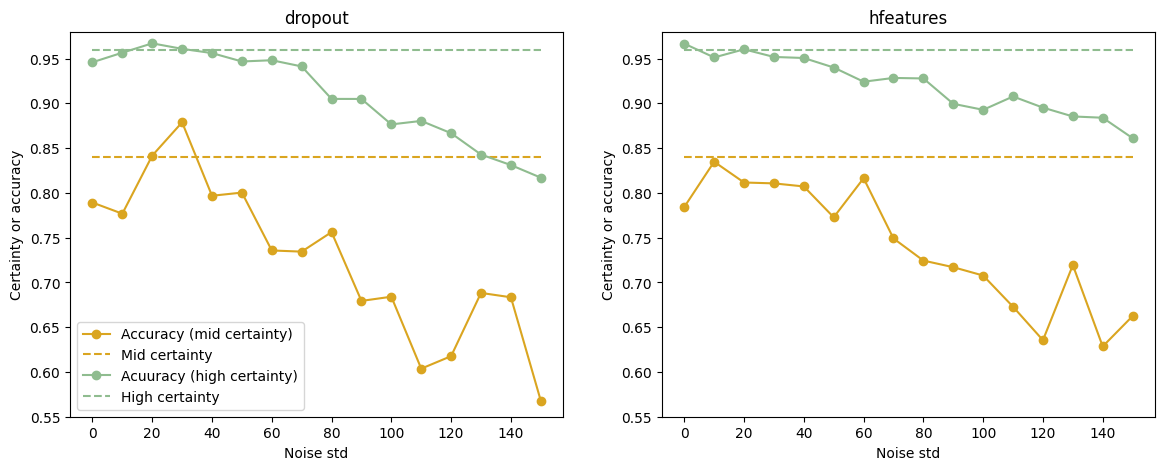

In [37]:
fig, axs = plt.subplots(1,2,figsize=(14,5))

c_ranges = np.stack((np.arange(25,29),np.arange(31,35)),axis=1)
color_names = ['goldenrod','darkseagreen']

for i,type in enumerate(estimator_type):

    for c in range(2):
        pred_acc = uncertainty_drops_noise[type][drop_name]['acc_bin']

        axs[i].plot(noise_levels,np.mean(pred_acc[:,c_ranges[:,c]],axis=1),'o-',color=color_names[c])
        axs[i].plot(noise_levels,np.tile(np.mean(uncertainty_drops_noise['model confidence'][c_ranges[:,c]]),16),'--',color=color_names[c])
        axs[i].set(xlabel='Noise std',ylabel='Certainty or accuracy',title=type,ylim=[0.55,0.98])
    if i==0:
        axs[i].legend(['Accuracy (mid certainty)', 'Mid certainty','Acuuracy (high certainty)','High certainty'])
plt.show()

Here, the over-estimation of certainty is quite evident under high noise level for both models. Let's then check how certainty estimation relates to CNN model accuracy.

In [38]:
acc_masking_noise = []
for type in estimator_type:
    inst = uncertainty_drops_noise[type][drop_name]['validation']['wrong']
    n_total = inst.size(1)
    n_wrong = torch.sum(inst,1)
    acc_masking_noise.append(1-n_wrong/n_total)
    
total_binned_error_noise = calculate_total_error(uncertainty_drops_noise, noise_levels)

16


In [35]:
from scipy.optimize import curve_fit

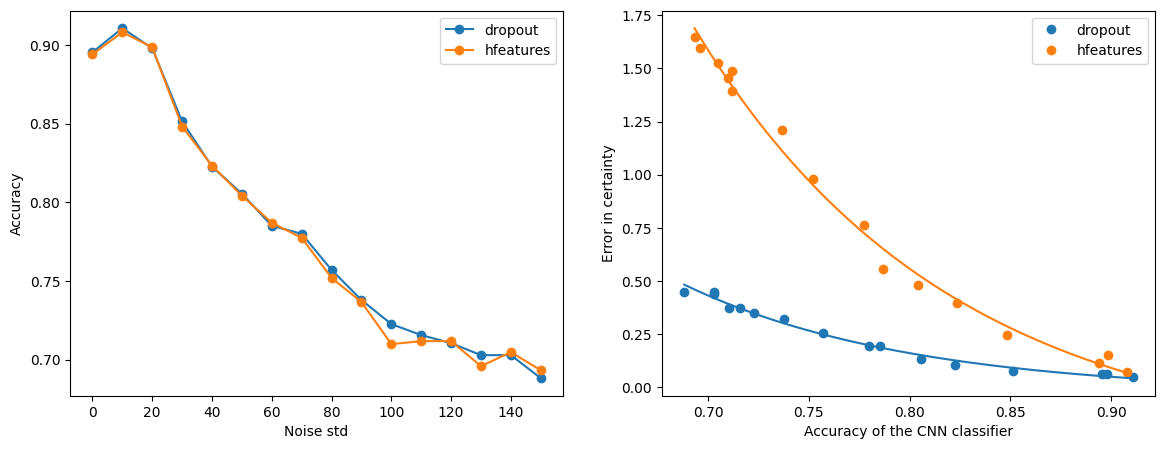

In [89]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
x_names = ['Fraction masked','Certainty']
y_names = 'Accuracy'

for i,type in enumerate(estimator_type):
    axs[0].plot(noise_levels,acc_masking_noise[i],'o-')
    axs[0].set(xlabel='Noise std',ylabel='Accuracy')
    axs[0].legend(estimator_type)
    
    pred_acc = uncertainty_drops_noise[type][drop_name]['acc_bin']
    axs[1].plot(acc_masking_noise[i],total_binned_error_noise[:,i],'o')
    axs[1].set(xlabel='Accuracy of the CNN classifier',ylabel='Error in certainty')
    axs[1].legend(estimator_type)
    
# Define an exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Get the default color cycle
colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

params1_noise = 0
for i in range(2):
    params1_noise, _ = curve_fit(exp_decay, np.array(acc_masking_noise[i]),total_binned_error_noise[:,i],p0=[50,7,0])

    xfit = np.arange(torch.min(acc_masking_noise[i]),torch.max(acc_masking_noise[i]),0.001)
    axs[1].plot(xfit,exp_decay(xfit,*params1_noise),color=colors_default[i])
    
plt.show()

The results show qualitatively the same relationships I observed before with masking-based corruption, now with a more resolved exponential increase in the total error in certainty with decreasing CNN accuracy. This corroborates the idea the out of distribution and high image corruption, which decreasy CNN accuracy in image classification, affect the estimation of certainty of CNN predictions. In real life applications, this factors should be taken into consideration when implementing certainty estimation. In order to get reliable certainty estimates, efforts should be taken to keep input images within the range of training data set.

## Conclusions

In this notebook I implemented a simple and effective method to estimate the certainty of a CNN classifier predictions. I take advantage of the known ability of logistic regression classifiers to output probability of a sample belonging to a certain class. In this context, the derived estimators output the probability of a given CNN prediction being actually true. I show that this approach allows direct estimation of prediction certainty without requiring further calibrations.
The certainty estimators' performance is quite decent for a wide range of image corruption extent either by masking or noise addition, showcasing its usefullness in real-life applications.

## Limitations
- The results show that extreme image corruption dereases both CNN accuracy and the performance of certainty estimation. Thus, in order to get reliable certainty estimates in real life applications, efforts should be taken to keep input images within the range of training data set.
  
- The droupout-based certainty estimation at 2% dropout extent provided the best results. However, in real-life the applicability of such approach might be limitted by computational resources, since it requires many (here 50) forward passes on the CNN to get the estimate. Alternatively, using plain deterministic CNN output (dropout of zero) provided a decent performance, even slighlt better then the hfeatures-based approach.

## Mixture of estimators for applications with known image masking level

In [25]:
from scipy.interpolate import CubicSpline

class LogisticRegressionMix():
    def __init__(self, C, mask_levels):
        self.mask_levels = mask_levels
        self.C = C
        
    def fit(self, X, y):
        self.y = y
        self.mixclf = []
        for i in range(X.size(0)):
            Xtrain = X[i,:,:].cpu()
            ytrain = y[i,:].squeeze()
            self.mixclf.append(LogisticRegression(C=self.C,random_state=0,max_iter=3000).fit(Xtrain, ytrain))
        return self
    
    def predict_proba(self, Xtest, mask_levels=None):
        
        def direct_clf(X):
            y = np.zeros((X.shape[0],X.shape[1]))
            for i, clf in enumerate(self.mixclf):
                #print(clf)
                y[i,:] = clf.predict_proba(X[i,:,:])[:,1]
            return y
        
        def interp_clf(X):
            # Assumes just one instance to predict
            if X.dim()<3:
                X = X.unsqueeze(0)
            
            y = np.zeros((len(self.mixclf),X.shape[1]))
            
            for i, clf in enumerate(self.mixclf):
                #print(clf)
                y[i,:] = clf.predict_proba(X[0,:,:])[:,1]
            return y

        def confidence_interpolate(y, level):
            #print(self.mask_levels.shape,y.shape)
            cs = CubicSpline(self.mask_levels,y)
            return cs(level)
        
        
        if mask_levels is None:
            ypred = direct_clf(Xtest)
        else:    
            yall = interp_clf(Xtest)
            #print(np.array(mask_levels).shape)
            
            if not isinstance(mask_levels, (list, np.ndarray)):
                mask_levels = [mask_levels]
            
            yinterp = np.zeros((len(mask_levels),yall.shape[1]))
            
            for i,level in enumerate(mask_levels):
                for p in range(yall.shape[1]):
                    yinterp[i,p] = confidence_interpolate(yall[:,p],level)
            ypred = yinterp
        
        return ypred
                    
                

def train_estimator_mix(masking_levels,C=[1,1],dropout_predictions=False,features_file = 'uncertainty_all.pth',clf=None):
    uncertainty_drops = {}
    
    
    for type in estimator_type:
        uncertainty_drops[type] = {key: {} for key in drop_names}
    
    for drop_name in drop_names:
        
        model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop_name}_nonorm_masked_extendedtrain06/29_05_2024"
        
        uncertainty_tm = torch.load(os.path.join(model_path,features_file))
        
        for i, type in enumerate(estimator_type):
        
            print(drop_name)
            
            for key in ['train','validation']:
                uncertainty_drops[type][drop_name][key] = {}
                for data_name in ['features','wrong']:
                    uncertainty_drops[type][drop_name][key][data_name] = uncertainty_tm[key][data_name][type]
            
            #fit logistic model
            if dropout_predictions:
                pred_type = 'dropout'
            else:
                pred_type = type
                
            fts = uncertainty_drops[type][drop_name]['train']['features']
            wrong = uncertainty_drops[pred_type][drop_name]['train']['wrong']
            Xtrain = fts
            #print(Xtrain.shape,wrong.shape)
            #gind = np.apply_along_axis(lambda x: np.where(np.isnan(x)==0)[0], 0, Xtrain[:,:,1])
            #print(gind.shape)
            #Xtrain = Xtrain[gind[:,0],gind[:,1]]
            wrong_train = wrong
            y = np.apply_along_axis(lambda x: np.where(x==0,1,0),0,wrong_train)
            #print(y.shape)
            #fit classifier
            if not clf:
                uncertainty_drops[type][drop_name]['clf'] = LogisticRegressionMix(C=C[i],mask_levels=masking_levels).fit(Xtrain, y)
            else:
                uncertainty_drops[type][drop_name]['clf'] = clf[type][drop_name]['clf']
    
    return uncertainty_drops

In [28]:
dropouts = [0.02]
drop_names = ['002']
#estimate_mix = train_estimator_mix(fraction_levels,C=[1,0.02])
#uncertainty_drops_mix = get_estimator_accuracy(estimate_mix,estimator_mix=True,masking_levels=fraction_levels)
stats_mix = get_estimator_stats(uncertainty_drops_mix,corruption_levels=fraction_levels)

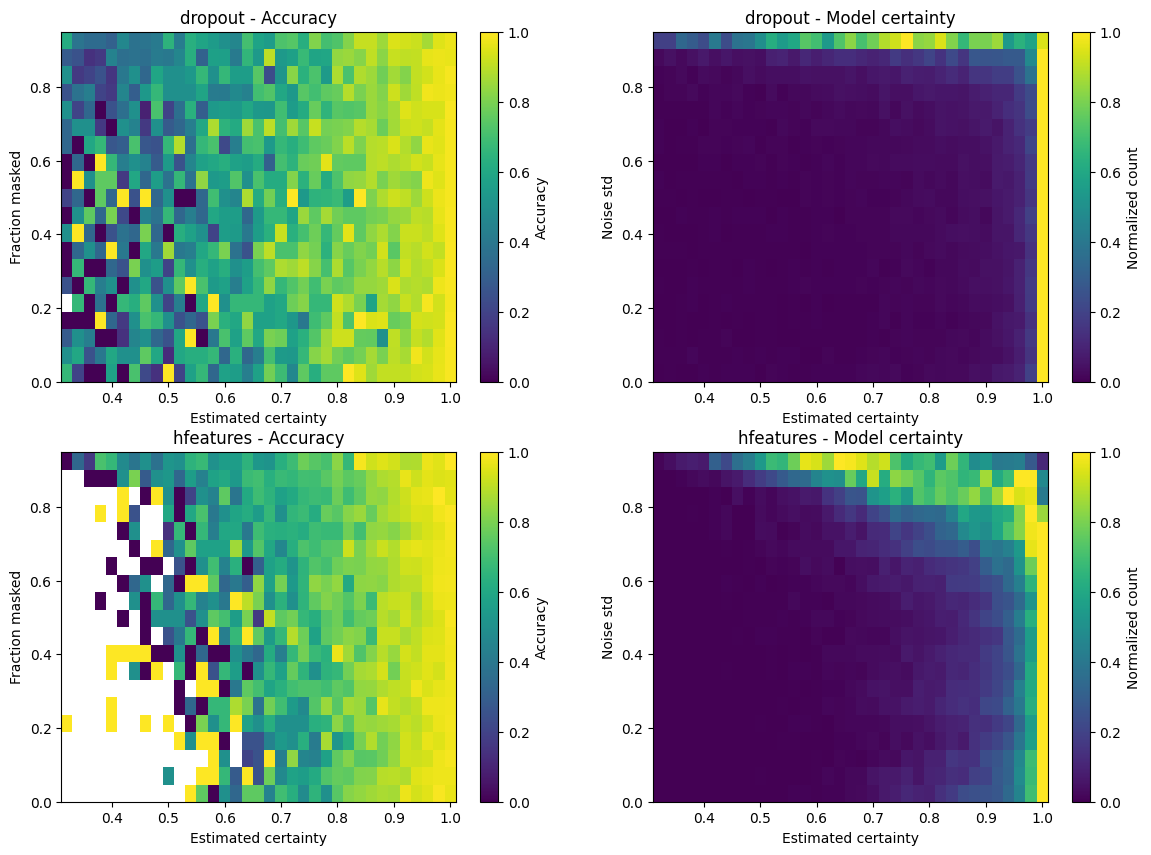

In [29]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
drop_name = '002'
title_names = ['Accuracy','Model certainty']

for i,type in enumerate(estimator_type):

    pred_acc = uncertainty_drops_mix[type][drop_name]['acc_bin']
    predm = uncertainty_drops_mix[type][drop_name]['conf_bin']
    
    pcm1 = axs[i,1].imshow(predm, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,1].set(xlabel='Estimated certainty',ylabel='Noise std',title=f"{type} - {title_names[1]}")

    pcm2 = axs[i,0].imshow(pred_acc, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,0].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[0]}")
    cbar = fig.colorbar(pcm2,ax=axs[i,0])
    cbar.set_label('Accuracy')
    cbar2 = fig.colorbar(pcm1,ax=axs[i,1])
    cbar2.set_label('Normalized count')
plt.show()

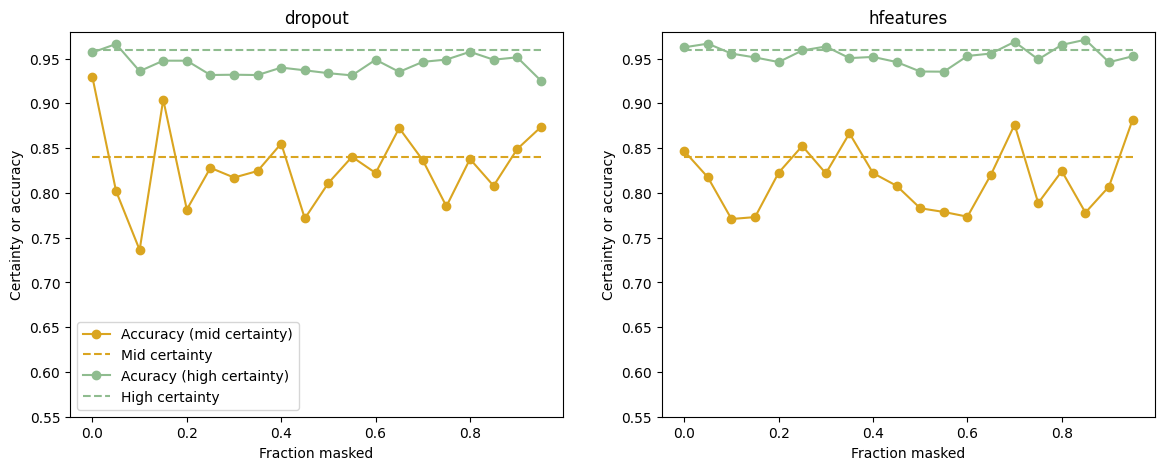

In [31]:
fig, axs = plt.subplots(1,2,figsize=(14,5))

c_ranges = np.stack((np.arange(25,29),np.arange(31,35)),axis=1)
color_names = ['goldenrod','darkseagreen']

for i,type in enumerate(estimator_type):

    for c in range(2):
        pred_acc = uncertainty_drops_mix[type][drop_name]['acc_bin']

        axs[i].plot(fraction_levels,np.mean(pred_acc[:,c_ranges[:,c]],axis=1),'o-',color=color_names[c])
        axs[i].plot(fraction_levels,np.tile(np.mean(uncertainty_drops_mix['model confidence'][c_ranges[:,c]]),20),'--',color=color_names[c])
        axs[i].set(xlabel='Fraction masked',ylabel='Certainty or accuracy',title=type,ylim=[0.55,0.98])
    if i==0:
        axs[i].legend(['Accuracy (mid certainty)', 'Mid certainty','Acuracy (high certainty)','High certainty'])
plt.show()

In [33]:
acc_masking_mix = []
for type in estimator_type:
    inst = uncertainty_drops_mix[type][drop_name]['validation']['wrong']
    n_total = inst.size(1)
    n_wrong = torch.sum(inst,1)
    acc_masking_mix.append(1-n_wrong/n_total)
    
total_binned_error_mix = calculate_total_error(uncertainty_drops_mix,fraction_levels)

20


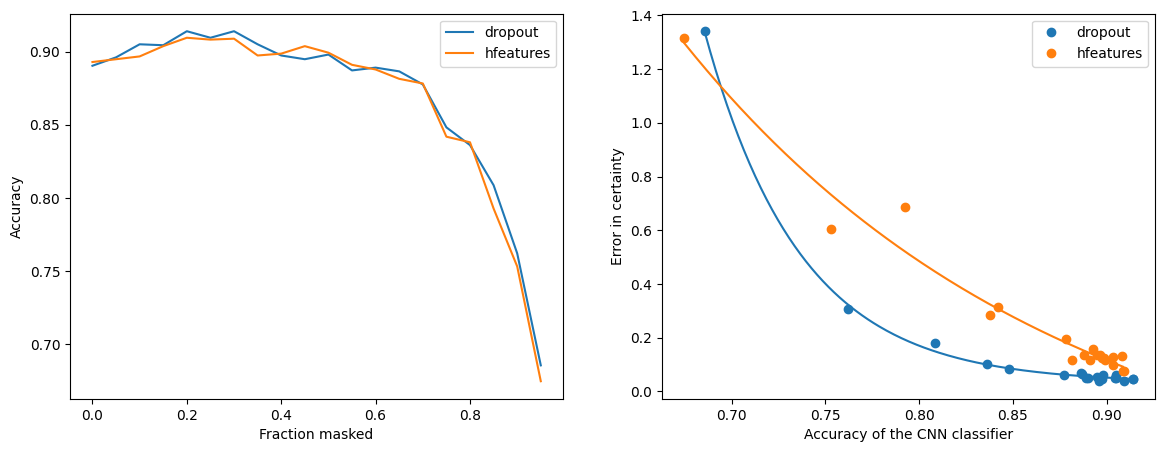

In [36]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
x_names = ['Fraction masked','Certainty']
y_names = 'Accuracy'

for i,type in enumerate(estimator_type):
    axs[0].plot(fraction_levels,acc_masking_mix[i])
    axs[0].set(xlabel='Fraction masked',ylabel='Accuracy')
    axs[0].legend(estimator_type)
    
    pred_acc = uncertainty_drops_mix[type][drop_name]['acc_bin']
    #axs[1].plot(np.mean(pred_acc[:,c_ranges[:,2]],axis=1),acc_masking[i],'o')
    axs[1].plot(acc_masking_mix[i],total_binned_error_mix[:,i],'o')
    axs[1].set(xlabel='Accuracy of the CNN classifier',ylabel='Error in certainty')
    axs[1].legend(estimator_type)

# Define an exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Get the default color cycle
colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(2):
    params1, _ = curve_fit(exp_decay, np.array(acc_masking_mix[i]),total_binned_error_mix[:,i],p0=[50,7,0])
    
    xfit = np.arange(torch.min(acc_masking_mix[i]),torch.max(acc_masking_mix[i]),0.001)
    axs[1].plot(xfit,exp_decay(xfit,*params1),color=colors_default[i])
    
plt.show()